In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [ ]:
path = "Folhas/Teste01.png"
im0 = cv2.imread(path)

In [ ]:
plt.imshow(im0)
plt.show()
print(np.shape(im0))

In [ ]:
### Algoritmo Seguidor de Fronteira

height = np.shape(im0)[0]
width = np.shape(im0)[1]

b_0 = (0, 1)
c_0 = (0, 0)

b_1 = 0
c_1 = 0

b = 0
c = 0



In [96]:
neighbors = {
    "n_1": [-1, 0],
    "n_2": [-1,-1],
    "n_3": [ 0,-1],
    "n_4": [ 1,-1],
    "n_5": [ 1, 0],
    "n_6": [ 1, 1],
    "n_7": [ 0, 1],
    "n_8": [-1, 1]
}

In [98]:
##TODO função de percorrer dicionário
# func(b, n)
# retornar proximo_n

In [ ]:
teste = np.array([[0,0,0,0,0,0,0],
              [0,0,1,1,1,1,0],
              [0,1,0,0,1,0,0],
              [0,0,1,0,1,0,0],
              [0,1,0,0,1,0,0],
              [0,1,1,1,1,0,0],
              [0,0,0,0,0,0,0]])

In [88]:
height = np.shape(teste)[0]
width = np.shape(teste)[1]

b_0 = np.array([0, 1])
c_0 = np.array([0, 0])

b_1 = 0
c_1 = 0

b = 0
c = 0

In [93]:
#while percorre pixels brancos até achar o primeiro não branco
while teste[b_0[0], b_0[1]]==0:
    if b_0[1]!= width-1:
        b_0+=[0,1]
    else:
        b_0+=[1,-width+1]
print(b_0)

[1 2]


In [94]:
c_0 = b_0 - [0,1]
print(c_0)

[1 1]


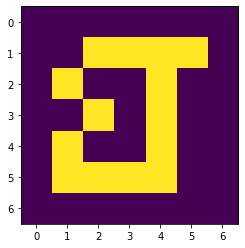

(7, 7)


In [73]:
plt.imshow(teste)
plt.show()
print(np.shape(teste))